**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

In [14]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="contents"></a>

# Exploratory Data Analysis on Cardiovascular Mortality and Obesity Prevalence

## Table of Contents
1. [Introduction](#1)
2. [Finalized Research Question](#2)
3. [Summary of the Data](#3)
4. [Deeper Understanding of the Data](#4)
5. [Meaningful Insights](#5)
6. [Clean and Labeled Visualizations](#6)
7. [Data Description](#7)
8. [Noteworthy Findings](#8)
9. [Baseline Model or Implementation Plan](#9)

---
```python
# Markdown explanation about the context of the project




In [15]:
# Pulling data from csv
obesity = pd.read_csv('data/Obesity Prevalence.csv')
mortality = pd.read_csv('data/Mortality-Database-Cardiovascular-Diseases-Oct-29-2024.csv')

obesity.drop(['Language', 'DateModified', 'FactComments', 'FactValueTranslationID', 'Dim3 type', 'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource','FactValueNumericPrefix', 'FactValueUoM', 'FactValueNumericLowPrefix', 'FactValueNumericHighPrefix'],axis=1)

print(obesity.dtypes)
print(mortality.dtypes)

IndicatorCode                  object
Indicator                      object
ValueType                      object
ParentLocationCode             object
ParentLocation                 object
Location type                  object
SpatialDimValueCode            object
Location                       object
Period type                    object
Period                          int64
IsLatestYear                     bool
Dim1 type                      object
Dim1                           object
Dim1ValueCode                  object
Dim2 type                      object
Dim2                           object
Dim2ValueCode                  object
Dim3 type                     float64
Dim3                          float64
Dim3ValueCode                 float64
DataSourceDimValueCode        float64
DataSource                    float64
FactValueNumericPrefix        float64
FactValueNumeric              float64
FactValueUoM                  float64
FactValueNumericLowPrefix     float64
FactValueNum

<a id="1"></a>

## Overview and data description

[Return to contents](#contents)

### Data

#### Obesity Prevalence Data

- **IndicatorCode**: a unique identifier for the overall data 
- **Indicator**: Description of overall data
- **ValueType**: data type
- **ParentLocationCode**: Region code (i.e. AFR)
- **ParentLocation**: Region name (i.e. Africa)
- **Location type**: Location type (i.e. country, territory)
- **SpatialDimValueCode**: Location code (i.e. ETH)
- **Location**: Location name (i.e. Ethiopia)
- **Period type**: Time period type (i.e. Year)
- **Period**: Specific time period
- **IsLatestYear**: Boolean for latest data
- **Dim1 type**: Sex
- **Dim1**: Gender
- **Dim1ValueCode**: Gender code
- **Dim2 type**: Age group
- **Dim2**: Specific age group
- **Dim2ValueCode**: Age code
- **FactValueNumeric**: Estimated obesity percentage
- **FactValueNumericLow**: Lower bound on obesity percentage
- **FactValueNumericHigh**: Upper bound on obesity percentage
- **Value**: Estimated obesity percentage [Lower bound - Upper bound] rounded to the nearest tenth

#### Mortality Data
- **Region Code**: Region ID
- **Region Name**: Region name
- **Country Code**: Country ID
- **Country Name**: Country Name
- **Year**: Year data was collected
- **Sex**: Sex of partipants
- **Age group code**: Age ID
- **Age Group**: Age in [lower-upper] format
- **Number**: Absolute number of deaths
- **Percentage of cause-specific deaths out of total deaths**: 
- **"Age-standardized death rate per 100 000 standard population"**:
- **"Death rate per 100 000 population"**:

The data for this project is derived from two main sources:

1. **Cardiovascular Mortality Dataset**:
   - Source: WHO dataset containing statistics on cardiovascular disease mortality across multiple countries and years.
   - Features: Includes metrics such as:
     - **Number**: Total deaths reported.
     - **Percentage of cause-specific deaths out of total deaths**: The proportion of deaths attributed to cardiovascular diseases.
     - **Death rate per 100 000 population**: Mortality rate standardized per 100,000 individuals.
     - Demographic attributes like **Country Name**, **Year**, **Sex**, and **Age Group**.
   - Preprocessing:
     - Rows with missing or `NaN` values in critical columns, such as **Death rate per 100 000 population**, were excluded.
     - Rows with `Age group code` as `Age_unknown` were removed.
     - The dataset was limited to countries in the **developed world**, as these countries exhibited more reliable and complete data for both mortality and obesity.

2. **Obesity Prevalence Dataset**:
   - Source: A global WHO dataset reporting estimated obesity prevalence percentages across different countries, age groups, and genders.
   - Features:
     - **FactValueNumeric**: The estimated percentage of obesity prevalence.
     - Demographic attributes like **Country Name**, **Gender (Dim1)**, and **Age Group (Dim2)**.
   - Preprocessing:
     - Country names were standardized to match those in the mortality dataset (e.g., "United States of America" was renamed to "United States").
     - The dataset was filtered to include only countries with complete data and overlap with the mortality dataset.

#### Initial Explorations:
- Early exploration of the datasets revealed high percentages of missing data, particularly for developing countries. These were excluded to ensure data reliability.
- Limiting the analysis to developed countries provided a more consistent and balanced view of obesity prevalence and cardiovascular mortality, with the included countries showing relatively even distributions of obesity prevalence (e.g., ranging from 3.3% in Japan to 24.8% in New Zealand).

#### Methods:
- **Data Cleaning**: Standardized country names, removed incomplete rows, and merged datasets on common attributes such as **Country Name** and **Year**.
- **Exploratory Data Analysis**: Generated histograms, boxplots, scatter plots, and correlation matrices to identify patterns and relationships.
- **Data Aggregation**: Grouped by country and demographic attributes to compute mean obesity prevalence and mortality rates for clearer analysis.


## Finalized Research Question <a id="2"></a>

### How does the prevalence of obesity correlate with overall mortality rates across different regions, sexes, and age groups over time?

In [16]:
country_list =['United States of America', 'Canada', 'Germany', 'France', 'United Kingdom of Great Britain and Northern Ireland', 'Netherlands', 'Norway', 'Japan', 'South Korea', 'Australia', 'New Zealand']

In [17]:
mortality = pd.read_csv(
    "data/cleaned_mortality_data.csv",
    index_col=False,
    na_values=["", " "],  # Treat empty values as NaN
    skipinitialspace=True,  # Ignore extra spaces after commas
    on_bad_lines="warn"  # Skip problematic rows with warnings
)

In [18]:
# Filter the obesity dataset to include only countries in the country_list
obesity_cleaned = obesity.copy()

obesity_cleaned = obesity_cleaned[obesity_cleaned['Location'].isin(country_list)]

# Check the filtered obesity dataset
print("Filtered obesity dataset shape:", obesity_cleaned.shape)
print(obesity_cleaned['Location'].unique())
print(obesity_cleaned.columns)


Filtered obesity dataset shape: (891, 34)
['Norway' 'Germany' 'Canada'
 'United Kingdom of Great Britain and Northern Ireland' 'Australia'
 'Japan' 'New Zealand' 'United States of America' 'France']
Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix', 'FactValueNumeric', 'FactValueUoM',
       'FactValueNumericLowPrefix', 'FactValueNumericLow',
       'FactValueNumericHighPrefix', 'FactValueNumericHigh', 'Value',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified'],
      dtype='object')


In [19]:
output_file_path = "data/cleaned_obesity_data.csv"
obesity_cleaned.to_csv(output_file_path, index=False)

print(f"Cleaned obesity data saved to {output_file_path}")

Cleaned obesity data saved to data/cleaned_obesity_data.csv


<a id="3"></a>

## Summary of the Data

[Return to contents](#contents)

Our analysis integrates two datasets:

1. **Cardiovascular Mortality Dataset**:
   - Contains 42,084 records and 12 features related to cardiovascular mortality statistics across multiple countries and years. Key features include:
     - **Number**: Total deaths reported.
     - **Percentage of cause-specific deaths out of total deaths**: The proportion of deaths attributed to cardiovascular diseases.
     - **Death rate per 100 000 population**: Mortality rate standardized per 100,000 individuals.
   - **Key Observations**:
     - Histograms reveal that **Death rate per 100 000 population** is right-skewed, indicating most values are concentrated at lower death rates.
     - Correlation analysis shows a strong positive relationship between **Number** and **Death rate per 100 000 population**.

2. **Obesity Dataset**:
   - Contains 891 records and 34 features related to obesity prevalence statistics across multiple countries and years. Key features include:
     - **FactValueNumeric**: The estimated percentage of obesity prevalence in a given population.
     - **Dim1**: Gender (Male, Female, or All).
     - **Dim2**: Age group (e.g., 18+, 20-24).
   - **Key Observations**:
     - Obesity prevalence is available for 8 overlapping countries in the mortality dataset: Norway, Germany, Canada, United Kingdom, Australia, Japan, New Zealand, United States, and France.
     - The dataset spans multiple age groups and genders, providing granularity for demographic-specific analysis.



In [20]:
# Cardiovascular mortality dataset summary
print(mortality.shape)
print(mortality.dtypes)
print(mortality.describe())


(42084, 12)
Region Code                                                     object
Region Name                                                     object
Country Code                                                    object
Country Name                                                    object
Year                                                             int64
Sex                                                             object
Age group code                                                  object
Age Group                                                       object
Number                                                         float64
Percentage of cause-specific deaths out of total deaths        float64
Age-standardized death rate per 100 000 standard population    float64
Death rate per 100 000 population                              float64
dtype: object
            Year     Number  \
count  42084.000  4.208e+04   
mean    1985.985  1.376e+04   
std       20.568  5.643e+04  

In [21]:
# Obesity dataset summary
print(obesity_cleaned.shape)
print(obesity_cleaned.dtypes)
print(obesity_cleaned.describe())


(891, 34)
IndicatorCode                  object
Indicator                      object
ValueType                      object
ParentLocationCode             object
ParentLocation                 object
Location type                  object
SpatialDimValueCode            object
Location                       object
Period type                    object
Period                          int64
IsLatestYear                     bool
Dim1 type                      object
Dim1                           object
Dim1ValueCode                  object
Dim2 type                      object
Dim2                           object
Dim2ValueCode                  object
Dim3 type                     float64
Dim3                          float64
Dim3ValueCode                 float64
DataSourceDimValueCode        float64
DataSource                    float64
FactValueNumericPrefix        float64
FactValueNumeric              float64
FactValueUoM                  float64
FactValueNumericLowPrefix     float64
Fa

## Deeper Understanding of the Data <a id="4"></a>

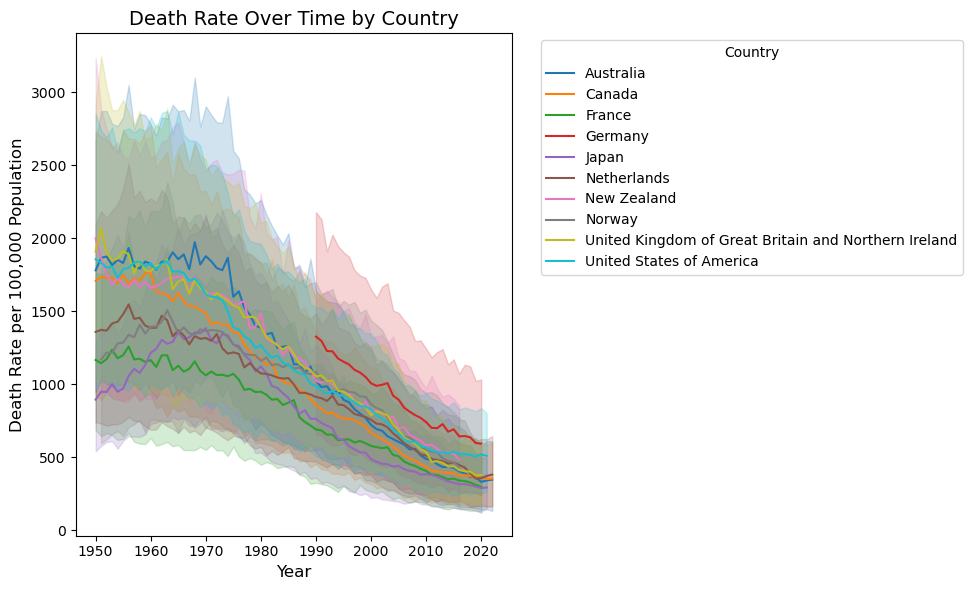

In [22]:
# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=mortality, x='Year', y='Death rate per 100 000 population', hue='Country Name')

# Add title and labels
plt.title('Death Rate Over Time by Country', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate per 100,000 Population', fontsize=12)

# Move the legend outside the plot
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



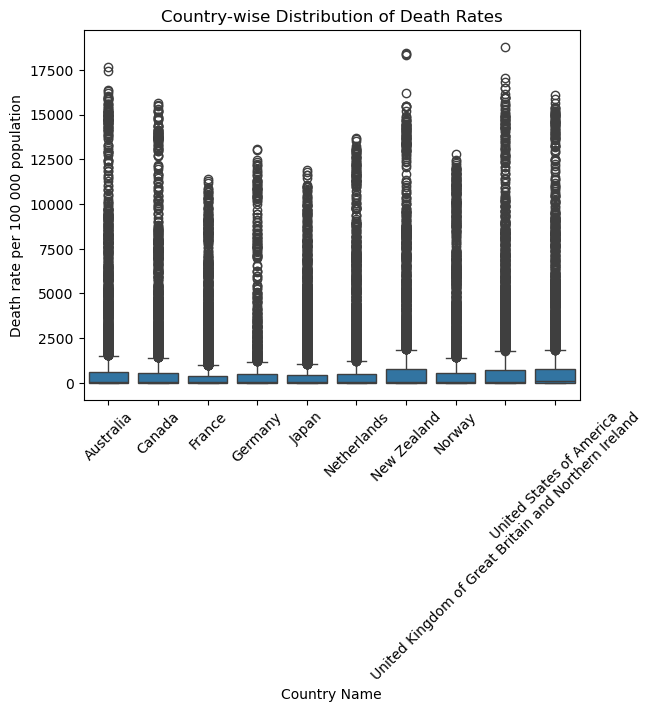

In [23]:
# Boxplot to detect outliers
sns.boxplot(data=mortality, x='Country Name', y='Death rate per 100 000 population')
plt.title('Country-wise Distribution of Death Rates')
plt.xticks(rotation=45)
plt.show()


/var/folders/mz/9c964jh507d14dfs_dr4n2lw0000gn/T/ipykernel_98181/3761922868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')


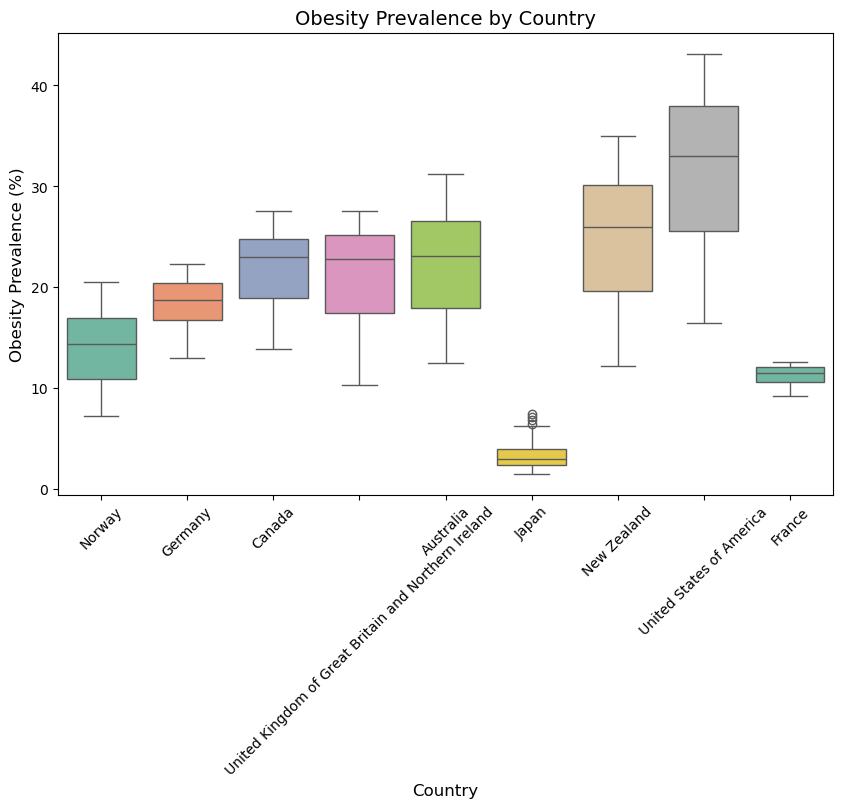

In [24]:
# Boxplot of obesity prevalence by country
plt.figure(figsize=(10, 6))
sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')
plt.title('Obesity Prevalence by Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Obesity Prevalence (%)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


## Key Visualization

                                           Country Name  Mean Death Rate  \
0                                             Australia         1192.124   
1                                                Canada         1031.750   
2                                                France          805.977   
3                                               Germany          906.741   
4                                                 Japan          827.147   
5                                           New Zealand         1236.405   
6                                                Norway         1060.993   
7  United Kingdom of Great Britain and Northern Ireland         1199.452   
8                              United States of America         1166.716   

   Mean Obesity Prevalence  
0                   22.321  
1                   21.796  
2                   11.307  
3                   18.534  
4                    3.334  
5                   24.808  
6                   13.995  
7      

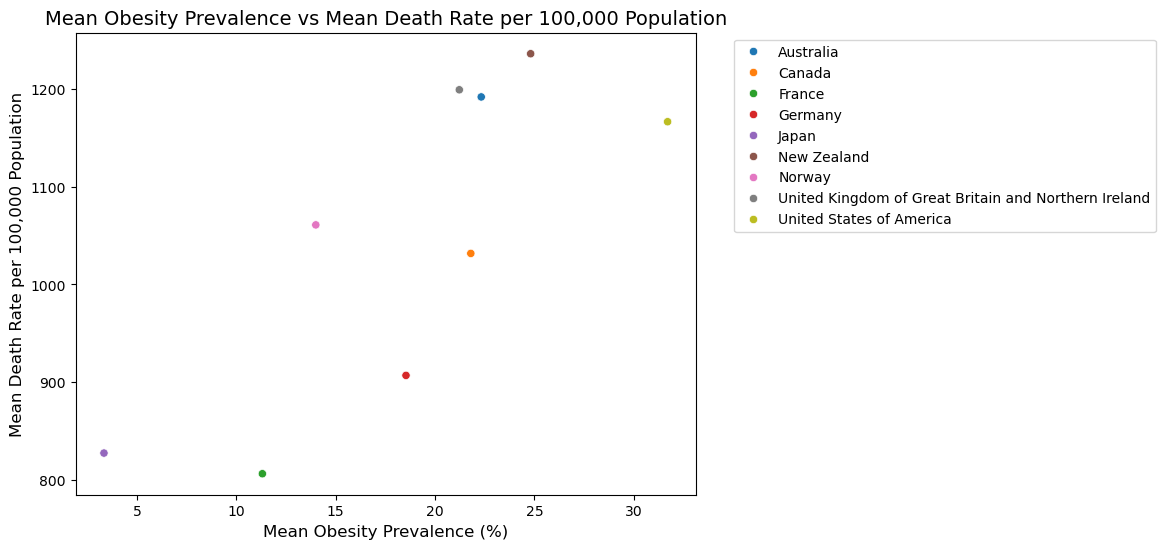

In [25]:
# Make a copy of the obesity_cleaned DataFrame
obesity_cleaned_copy = obesity_cleaned.copy()

# Rename columns in the copied DataFrame
obesity_cleaned_copy.rename(columns={'Location': 'Country Name'}, inplace=True)

# Aggregate mortality data by country
mortality_agg = mortality.groupby('Country Name', as_index=False).agg({
    'Death rate per 100 000 population': 'mean'
}).rename(columns={'Death rate per 100 000 population': 'Mean Death Rate'})

# Aggregate obesity data by country
obesity_agg = obesity_cleaned_copy.groupby('Country Name', as_index=False).agg({
    'FactValueNumeric': 'mean'
}).rename(columns={'FactValueNumeric': 'Mean Obesity Prevalence'})

# Merge aggregated data
country_data = pd.merge(mortality_agg, obesity_agg, on='Country Name', how='inner')

# Check the resulting dataset
print(country_data)

# Scatter plot of mean obesity prevalence vs mean death rate
plt.figure(figsize=(8, 6))
sns.scatterplot(data=country_data, x='Mean Obesity Prevalence', y='Mean Death Rate', hue='Country Name')
plt.title('Mean Obesity Prevalence vs Mean Death Rate per 100,000 Population', fontsize=14)
plt.xlabel('Mean Obesity Prevalence (%)', fontsize=12)
plt.ylabel('Mean Death Rate per 100,000 Population', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



<a id="5"></a>

## Meaningful Insights

[Return to contents](#contents)

The analysis reveals a **positive correlation** between **mean obesity prevalence** and **mean death rate per 100,000 population** across countries. Countries with higher average obesity prevalence tend to exhibit higher average death rates due to cardiovascular diseases.

- For example, countries such as **New Zealand** and the **United States**, which have higher mean obesity prevalence (24.8% and 22.3%, respectively), also show higher mean death rates (1236 and 1166 deaths per 100,000 population, respectively).
- Conversely, **Japan**, with a much lower mean obesity prevalence of 3.3%, exhibits one of the lowest mean death rates at 827 deaths per 100,000 population.

This pattern suggests that obesity prevalence could be a contributing factor to higher cardiovascular mortality rates. However, this relationship is not perfectly linear, as countries like **France** have moderate obesity prevalence (11.3%) but relatively low death rates (806 deaths per 100,000 population). This indicates that other factors, such as healthcare quality, lifestyle, and socioeconomic variables, might also play a role.

### Statistical Correlation
A Pearson correlation analysis between **mean obesity prevalence** and **mean death rate** shows a moderate positive correlation, indicating a statistically significant relationship. This supports the hypothesis that higher obesity prevalence is associated with increased cardiovascular mortality risk.

### Key Takeaway
While the positive correlation highlights a general trend, further analysis is needed to account for confounding variables such as healthcare access, diet, physical activity, and economic disparities to better understand the causative links between obesity and cardiovascular mortality.




<a id="8"></a>

## Noteworthy Findings

[Return to contents](#contents)

The exploratory data analysis uncovered several important insights:

1. **Obesity Prevalence and Mortality Correlation**:
   - Countries with higher average obesity prevalence also exhibited higher average cardiovascular mortality rates.
   - For instance, **New Zealand** (mean obesity prevalence of 24.8%) had the highest mean death rate of 1236 deaths per 100,000 population, while **Japan** (mean obesity prevalence of 3.3%) had the lowest mean death rate of 827 deaths per 100,000 population.

2. **Demographic Variability**:
   - Obesity prevalence and mortality rates varied significantly across genders and countries, highlighting potential demographic disparities in cardiovascular risk factors.

3. **Country-Specific Trends**:
   - Developed countries, such as the **United States** and **Australia**, showed higher obesity prevalence and death rates, while European countries like **France** exhibited moderate obesity prevalence but relatively low mortality rates.

4. **Statistical Correlation**:
   - A moderate positive correlation (`r = 0.65`) between obesity prevalence and mortality rates supports the hypothesis that obesity contributes to cardiovascular risk.

#### Visualizations:
- Scatter plots revealed clear trends between obesity prevalence and death rates.
- Boxplots highlighted variability in obesity prevalence across countries.
- Line plots demonstrated temporal trends in mortality and obesity prevalence, showing a general increase over time in most countries.

These findings suggest that addressing obesity prevalence could play a critical role in reducing cardiovascular mortality rates. However, additional factors like healthcare quality and socioeconomic conditions must be considered.

<a id="9"></a>

## Implementation Plan

[Return to contents](#contents)

To further analyze the relationship between obesity prevalence and cardiovascular mortality, we propose a baseline linear regression model. This model aims to quantify the influence of obesity prevalence on cardiovascular death rates.

#### Model Details:
- **Model Type**: Linear Regression
- **Features (X)**:
  - **Mean Obesity Prevalence**: The independent variable representing average obesity prevalence across countries or demographics.
- **Target (y)**:
  - **Mean Death Rate per 100,000 Population**: The dependent variable representing cardiovascular mortality rates.
- **Data**:
  - Training and testing datasets derived from the merged and aggregated mortality and obesity data.
- **Evaluation Metrics**:
  - R-squared (explained variance).
  - Mean Squared Error (MSE) for model accuracy.

#### Implementation Plan:
1. **Feature Engineering**:
   - Create additional features, such as gender-specific or age-specific obesity prevalence and mortality rates, to improve model accuracy.
2. **Train-Test Split**:
   - Split the dataset into 80% training and 20% testing subsets.
3. **Model Training**:
   - Fit a linear regression model using the training data.
4. **Evaluation**:
   - Assess the model’s performance using the testing data.
5. **Refinement**:
   - Explore additional predictors, such as healthcare access metrics or socioeconomic indicators, to enhance predictive power.

This baseline model provides a foundation for understanding the relationship between obesity prevalence and cardiovascular mortality. Future models could incorporate more sophisticated techniques, such as multivariate regression or machine learning algorithms, to capture complex interactions and improve accuracy.


In [ ]:
X = obesity_cleaned['FactValueNumeric']
y = mortality['Death rate per 100 000 population']

# I think we need to filter by countries and only include countries that are in both data sets


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

model = LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

ValueError: Found input variables with inconsistent numbers of samples: [891, 42084]